## The Most Overrated and Underrated Restaurants Nearby

### 1. Introduction/Business Problem

When people choose a new restaurant to try, they will often first go on-line to compare the ratings of several potential restaurants and then pick the one with higher rating to have their meals. In most cases, people tend to have very a high expectation for these highly rated restaurants. But the reality is that some of these restaurants may be overrated and the dining experience is not as pleasant as the website described. There are several reasons why a restaurant could be overrated. It might be that the restaurant is literally bad but happened to be rated by a very small group of people with high tolerance. It might also be due to intentional exaggeration by other raters for their own sake regardless of the restaurant's actual quality.

On the other hand, some restaurants may be underrated, even if they provide very good food and service at a relatively cheap price. When people just had a meal in these restaurants, they could only wish that they had known these restaurants much earlier.

Given that the on-line ratings might be misleading and could result in unwise choice of restaurants, it is important to build a system to detect the highly overrated and highly underrated restaurants around a location. Providing a list of these restaurants would benefit food lovers as they could avoid the overrated restaurants and try some of the underrated ones to have a better dining experience in the future.

In order to detect overrated and underrated restaurants, we are going to use the Foursquare API to **explore** the potential restaurants around a location (default is North York, ON). After getting their venue IDs, we will collect **venues** information of each restaurant, including **price**,  the count of **likes**, and their **rating**. Finally, we are going to utilize the multiple linear regression algorithm to make predictions to complete the task.

### 2. Data

First, we will get the latitude and longitude of a location (default is North York, ON).  

Second, we are going to use the **explore** function of Foursquare API to extract the venue IDs of recommended restaurants nearby.  

Third, based on each venue ID, we will use the **venues** function to get details of each restaurant, including **price**,  the count of **likes**, and their **rating**. The first two features are going to be used to contruct our indepedent variables, and the last one is used as our dependent variable in our multiple linear regression model.

#### 2.1. Get the latitude and longitude of a location

In [1]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install msgpack
!pip install geocoder
import geocoder

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    certifi-2018.10.15         |        py36_1000         138 KB  conda-forge
    geopy-1.17.0               |             py_0          49 KB  conda-forge
    ca-certificates-2018.10.15 |       ha4d7672_0         135 KB  conda-forge
    conda-4.5.11               |        py36_1000         651 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.1 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0            conda-forge
    geopy:           

In [2]:
# Input a location. Default is North York, ON.
address = 'North York, ON'
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(address, [latitude, longitude])

North York, ON [43.7709163, -79.4124102]


#### 2.2. Utilize the Foursquare API to explore the restaurants nearby

Define Foursquare Credentials and Version

In [3]:
# The code was removed by Watson Studio for sharing.

Get the top 50 venues that are within a radius of 1,000 meters

In [5]:
VERSION = '20181105'
radius = 1000 # within 1000 meters
LIMIT = 50 # maximum 50 venues
SECTION = 'food' # restaurants

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&section={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, SECTION)

Send the GET request and examine the resutls

In [6]:
import requests
results = requests.get(url).json()

In [7]:
count = len(results['response']['groups'][0]['items'])
def restaurant():
    if count <= 1:
        return 'restaurant' 
    else:
        return 'restaurants'

In [8]:
scope = round(radius/1000, 2)
if scope <= 1:
    km = 'km'
else:
    km = 'kms'

In [9]:
'{} {} are found within {} {} radius of {}.'.format(count, restaurant(), scope, km, address)

'50 restaurants are found within 1.0 km radius of North York, ON.'

Now we are ready to clean the json and structure it into a pandas dataframe

In [10]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '563d44fccd1044ad67a744fb',
  'name': "The Captain's Boil",
  'location': {'address': '5313 Yonge St',
   'lat': 43.773255217045026,
   'lng': -79.41380541792645,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.773255217045026,
     'lng': -79.41380541792645}],
   'distance': 283,
   'postalCode': 'M2N 5R4',
   'cc': 'CA',
   'city': 'Toronto',
   'state': 'ON',
   'country': 'Canada',
   'formattedAddress': ['5313 Yonge St', 'Toronto ON M2N 5R4', 'Canada']},
  'categories': [{'id': '4bf58dd8d48988d1ce941735',
    'name': 'Seafood Restaurant',
    'pluralName': 'Seafood Restaurants',
    'shortName': 'Seafood',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/seafood_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-3-563d44fccd1044ad67a744f

Create a dataframe that contains all restaurants around the input location

In [11]:
import pandas as pd
from pandas.io.json import json_normalize

In [12]:
dataframe = json_normalize(items) # flatten JSON
dataframe.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-563d44fccd1044ad67a744fb-0,"[{'id': '4bf58dd8d48988d1ce941735', 'name': 'S...",563d44fccd1044ad67a744fb,5313 Yonge St,CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.77325521704502...",43.773255,-79.413805,NaN,M2N 5R4,ON,The Captain's Boil,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-5a35b4443abcaf37eb1a0d88-1,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",5a35b4443abcaf37eb1a0d88,NaN,CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.7665789176648,...",43.766579,-79.412131,Willowdale,M2N 5P1,ON,The Keg,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-529f667511d2b09b2a210b5f-2,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",529f667511d2b09b2a210b5f,5314 Yonge St,CA,Toronto,Canada,at McKee Ave,...,"[{'label': 'display', 'lat': 43.77305366245606...",43.773054,-79.414082,NaN,M2N 6V1,ON,Burrito Boyz,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-5a02789d0a464d3112a58785-3,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",5a02789d0a464d3112a58785,5051 Yonge St,CA,Toronto,Canada,btwn Elmwood & Hillcrest Ave,...,"[{'label': 'display', 'lat': 43.76699771023422...",43.766998,-79.412222,Willowdale,M2N 5P2,ON,Konjiki Ramen,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-53c7201c498ef6785edb6856-4,"[{'id': '4bf58dd8d48988d113941735', 'name': 'K...",53c7201c498ef6785edb6856,5310 Yonge St,CA,NaN,Canada,NaN,...,"[{'label': 'display', 'lat': 43.77300999884723...",43.773010,-79.413875,NaN,M2N 5P9,NaN,Dakgogi,0,[],NaN


In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,The Captain's Boil,Seafood Restaurant,5313 Yonge St,CA,Toronto,Canada,NaN,283,"[5313 Yonge St, Toronto ON M2N 5R4, Canada]","[{'label': 'display', 'lat': 43.77325521704502...",43.773255,-79.413805,NaN,M2N 5R4,ON,563d44fccd1044ad67a744fb
1,The Keg,Steakhouse,NaN,CA,Toronto,Canada,NaN,483,"[Toronto ON M2N 5P1, Canada]","[{'label': 'display', 'lat': 43.7665789176648,...",43.766579,-79.412131,Willowdale,M2N 5P1,ON,5a35b4443abcaf37eb1a0d88
2,Burrito Boyz,Burrito Place,5314 Yonge St,CA,Toronto,Canada,at McKee Ave,273,"[5314 Yonge St (at McKee Ave), Toronto ON M2N ...","[{'label': 'display', 'lat': 43.77305366245606...",43.773054,-79.414082,NaN,M2N 6V1,ON,529f667511d2b09b2a210b5f
3,Konjiki Ramen,Ramen Restaurant,5051 Yonge St,CA,Toronto,Canada,btwn Elmwood & Hillcrest Ave,436,"[5051 Yonge St (btwn Elmwood & Hillcrest Ave),...","[{'label': 'display', 'lat': 43.76699771023422...",43.766998,-79.412222,Willowdale,M2N 5P2,ON,5a02789d0a464d3112a58785
4,Dakgogi,Korean Restaurant,5310 Yonge St,CA,NaN,Canada,NaN,261,"[5310 Yonge St, M2N 5P9, Canada]","[{'label': 'display', 'lat': 43.77300999884723...",43.773010,-79.413875,NaN,M2N 5P9,NaN,53c7201c498ef6785edb6856
5,Aroma Espresso Bar,Café,6 Parkhome,CA,North York,Canada,NaN,172,"[6 Parkhome, North York ON, Canada]","[{'label': 'display', 'lat': 43.76944882099181...",43.769449,-79.413081,NaN,NaN,ON,557767bc498ea4a20c8043f6
6,Sushi Bong,Sushi Restaurant,5 Northtown Way,CA,Toronto,Canada,at Yonge St,512,"[5 Northtown Way (at Yonge St), Toronto ON M2N...","[{'label': 'display', 'lat': 43.77542805510968...",43.775428,-79.413654,NaN,M2N 7A1,ON,4b2c1999f964a52098c124e3
7,Pastel Creperie & Dessert House,Creperie,5417 Yonge St,CA,Toronto,Canada,at Finch Ave.,617,"[5417 Yonge St (at Finch Ave.), Toronto ON M2N...","[{'label': 'display', 'lat': 43.77621893353755...",43.776219,-79.414648,NaN,M2N 5R6,ON,4d446252e198721e4c23bb8b
8,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥,Korean Restaurant,5445 Yonge St.,CA,Toronto,Canada,at Kempford Blvd.,728,"[5445 Yonge St. (at Kempford Blvd.), Toronto O...","[{'label': 'display', 'lat': 43.77721927435775...",43.777219,-79.414861,NaN,M2N 5S1,ON,4b5c97d1f964a520a83829e3
9,St. Louis Bar & Grill,Wings Joint,2050 Yonge St.,CA,Toronto,Canada,NaN,260,"[2050 Yonge St., Toronto ON M4S 1Z9, Canada]","[{'label': 'display', 'lat': 43.77304026482439...",43.773040,-79.413771,NaN,M4S 1Z9,ON,4b590484f964a520b27828e3


#### 2.3. Collect **venues** data of each restaurant, including **price**,  the count of **likes**, the count of **tips**, and their **rating**

In [15]:
ratings = list()
prices = list()
likes = list()
tips = list()

for venue_id in dataframe_filtered.id:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        ratings.append(result['response']['venue']['rating'])
    except:
        ratings.append(None)
    try:
        prices.append(result['response']['venue']['price']['tier'])
    except:
        prices.append(None)
    try:
        likes.append(result['response']['venue']['likes']['count'])
    except:
        likes.append(None)
    try:
        tips.append(result['response']['venue']['stats']['tipCount'])
    except:
        tips.append(None)

dataframe_filtered['rating'] = ratings
dataframe_filtered['price'] = prices
dataframe_filtered['likes'] = likes

In [16]:
restaurant = dataframe_filtered[['name','categories', 'address', 'postalCode', 'lat', 'lng', 'price', 'likes', 'rating']]
restaurant

,name,categories,address,postalCode,lat,lng,price,likes,rating
0,The Captain's Boil,Seafood Restaurant,5313 Yonge St,M2N 5R4,43.773255,-79.413805,3.0,41,8.1
1,The Keg,Steakhouse,NaN,M2N 5P1,43.766579,-79.412131,4.0,17,8.5
2,Burrito Boyz,Burrito Place,5314 Yonge St,M2N 6V1,43.773054,-79.414082,2.0,43,7.8
3,Konjiki Ramen,Ramen Restaurant,5051 Yonge St,M2N 5P2,43.766998,-79.412222,NaN,25,8.0
4,Dakgogi,Korean Restaurant,5310 Yonge St,M2N 5P9,43.773010,-79.413875,2.0,11,7.6
5,Aroma Espresso Bar,Café,6 Parkhome,NaN,43.769449,-79.413081,1.0,17,7.5
6,Sushi Bong,Sushi Restaurant,5 Northtown Way,M2N 7A1,43.775428,-79.413654,2.0,67,7.9
7,Pastel Creperie & Dessert House,Creperie,5417 Yonge St,M2N 5R6,43.776219,-79.414648,2.0,64,8.2
8,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥,Korean Restaurant,5445 Yonge St.,M2N 5S1,43.777219,-79.414861,1.0,98,8.4
9,St. Louis Bar & Grill,Wings Joint,2050 Yonge St.,M4S 1Z9,43.773040,-79.413771,2.0,60,7.3


### 3. Methodology

#### 3.1. Exploratory data analysis

In exploratory analysis, we first get the descriptive statistics for **price**, **likes**, and **rating**. Next, we plot the relationship between **price** and **rating** as well as the relationship between **likes**, and **rating**. Both **price** and **likes** display a positive tend with **rating**. Finally, we compute the Pearson correlation coefficients and perform ANOVA test to confirm that the positive correlations between **price** and **rating** and between **likes** and **rating** are statistically significant. Specifically, we find that we find that the Pearson correlation coefficient between **price** and **rating** is 0.34749699 with a P-value of 0.01934093 and the Pearson coefficient between the count of **likes** and **rating** is 0.51489608 with a P-value of 0.00029580.

**Delete missing values**

In [17]:
rated = restaurant[restaurant['rating'].notnull()]
rated

,name,categories,address,postalCode,lat,lng,price,likes,rating
0,The Captain's Boil,Seafood Restaurant,5313 Yonge St,M2N 5R4,43.773255,-79.413805,3.0,41,8.1
1,The Keg,Steakhouse,NaN,M2N 5P1,43.766579,-79.412131,4.0,17,8.5
2,Burrito Boyz,Burrito Place,5314 Yonge St,M2N 6V1,43.773054,-79.414082,2.0,43,7.8
3,Konjiki Ramen,Ramen Restaurant,5051 Yonge St,M2N 5P2,43.766998,-79.412222,NaN,25,8.0
4,Dakgogi,Korean Restaurant,5310 Yonge St,M2N 5P9,43.773010,-79.413875,2.0,11,7.6
5,Aroma Espresso Bar,Café,6 Parkhome,NaN,43.769449,-79.413081,1.0,17,7.5
6,Sushi Bong,Sushi Restaurant,5 Northtown Way,M2N 7A1,43.775428,-79.413654,2.0,67,7.9
7,Pastel Creperie & Dessert House,Creperie,5417 Yonge St,M2N 5R6,43.776219,-79.414648,2.0,64,8.2
8,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥,Korean Restaurant,5445 Yonge St.,M2N 5S1,43.777219,-79.414861,1.0,98,8.4
9,St. Louis Bar & Grill,Wings Joint,2050 Yonge St.,M4S 1Z9,43.773040,-79.413771,2.0,60,7.3


In [18]:
sample = rated.dropna(subset = ['price', 'likes']).reset_index(drop=True)
sample

,name,categories,address,postalCode,lat,lng,price,likes,rating
0,The Captain's Boil,Seafood Restaurant,5313 Yonge St,M2N 5R4,43.773255,-79.413805,3.0,41,8.1
1,The Keg,Steakhouse,NaN,M2N 5P1,43.766579,-79.412131,4.0,17,8.5
2,Burrito Boyz,Burrito Place,5314 Yonge St,M2N 6V1,43.773054,-79.414082,2.0,43,7.8
3,Dakgogi,Korean Restaurant,5310 Yonge St,M2N 5P9,43.773010,-79.413875,2.0,11,7.6
4,Aroma Espresso Bar,Café,6 Parkhome,NaN,43.769449,-79.413081,1.0,17,7.5
5,Sushi Bong,Sushi Restaurant,5 Northtown Way,M2N 7A1,43.775428,-79.413654,2.0,67,7.9
6,Pastel Creperie & Dessert House,Creperie,5417 Yonge St,M2N 5R6,43.776219,-79.414648,2.0,64,8.2
7,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥,Korean Restaurant,5445 Yonge St.,M2N 5S1,43.777219,-79.414861,1.0,98,8.4
8,St. Louis Bar & Grill,Wings Joint,2050 Yonge St.,M4S 1Z9,43.773040,-79.413771,2.0,60,7.3
9,Satay Sate,Indonesian Restaurant,5025 Yonge St,M2N 5P2,43.766690,-79.412100,2.0,7,7.5


**Descriptive Statistics**  
The **describe** function automatically computes basic statistics for all variables  
This will show:
- the count of that variable
- the mean
- the standard deviation (std) 
- the minimum value
- the IQR (Interquartile Range: 25%, 50% and 75%)
- the maximum value

In [19]:
sample[['price', 'likes', 'rating']].describe()

,price,likes,rating
count,45.000000,45.000000,45.000000
mean,1.711111,27.688889,7.102222
std,0.694858,30.374049,0.633349
min,1.000000,1.000000,6.000000
25%,1.000000,8.000000,6.600000
50%,2.000000,15.000000,7.100000
75%,2.000000,42.000000,7.500000
max,4.000000,140.000000,8.500000


**Value-Counts**  
Foursquare uses range 1 to 4 to capture **price** tier: 1 (least pricey) - 4 (most pricey). Value-counts helps to understand the number of observations within each price tier

In [20]:
price_counts = sample['price'].value_counts().to_frame()
price_counts.rename(columns={'price': 'value_counts'}, inplace=True)
price_counts.index.name = 'price'
price_counts

,value_counts
price,
2.0,23
1.0,18
3.0,3
4.0,1


In [21]:
sample_group=sample[['price','rating']]
sample_group=sample_group.groupby(['price'],as_index= False).mean()
sample_group

,price,rating
0,1.0,6.944444
1,2.0,7.117391
2,3.0,7.466667
3,4.0,8.500000


Based on the above sample_group table, the mean rating increases with price tier.

**Boxplots**  
Since **price** is a categorical variable, taking only four values (1, 2, 3, and 4), we visualize the relationship between "price" and "rating" by using boxplots.

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

(5.5, 8.625)

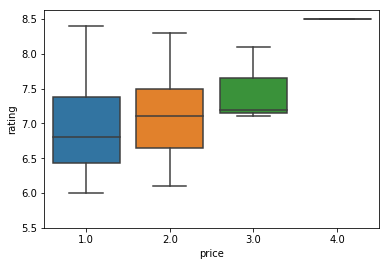

In [23]:
# price as potential predictor variable of price
sns.boxplot(x="price", y="rating", data=sample)
plt.ylim(5.5,)

The boxplot demonstrates that as **price** tier increases from 1 to 4, rating also sees a steady increase.

**Regplots**  
The count of **likes** and **rating** are continuous numerical variables. A great way of visualizing these variables is by using scatterplots with fitted lines.  
To understand the (linear) relationship between **likes** and **rating**, we can use "regplot", which plots the scatterplot plus the fitted regression line for the data.

(5.5, 9.505204184629891)

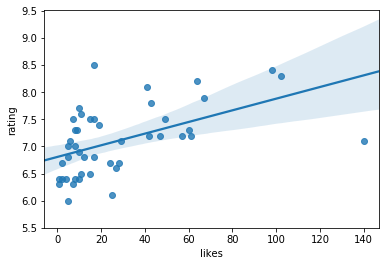

In [24]:
# like as potential predictor variable of price
sns.regplot(x="likes", y="rating", data=sample)
plt.ylim(5.5,)

As the count of **likes** goes up, the rating goes up: this indicates a positive direct correlation between these two variables.  The count of **likes** seems like a pretty good predictor of **rating**.

**Pearson Correlation**  
The Pearson Correlation measures the linear dependence between two variables, X and Y. The resulting coefficient is a value between -1 and 1 inclusive, where:
- **1**: total positive linear correlation,
- **0**: no linear correlation, the two variables most likely do not affect each other
- **-1**: total negative linear correlation.

In [25]:
sample[['price', 'likes', 'rating']].corr()

,price,likes,rating
price,1.000000,0.173322,0.347497
likes,0.173322,1.000000,0.514896
rating,0.347497,0.514896,1.000000


**P-Value**  
The P-value is the probability value that the correlation between these two variables is statistically significant. Normally, we choose a significance level of 0.05, which means that we are 95% confident that the correlation between the variables is significant. 
By convention, when the p-value is:
- < 0.001 we say there is strong evidence that the correlation is significant,
- < 0.05; there is moderate evidence that the correlation is significant,
- < 0.1; there is weak evidence that the correlation is significant, and
- is >  0.1; there is no evidence that the correlation is significant.

In [26]:
from scipy import stats

In [27]:
pearson_coef, p_value = stats.pearsonr(sample['price'], sample['rating'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.34749698987309646  with a P-value of P = 0.019340928747418013


In [28]:
pearson_coef, p_value = stats.pearsonr(sample['likes'], sample['rating'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.514896080450214  with a P-value of P = 0.0002958039337339162


**ANOVA: Analysis of Variance**  
The Analysis of Variance (ANOVA) is a statistical method used to test whether there are significant differences between the means of two or more groups. ANOVA returns two parameters:  
**F-test score**: ANOVA assumes the means of all groups are the same, calculates how much the actual means deviate from the assumption, and reports it as the F-test score. A larger score means there is a larger difference between the means.  
**P-value**:  P-value tells us the statistical significance of our calculated score value.  

In [29]:
sample_gptest=sample[['price','rating']]
sample_gptest=sample_gptest[['price','rating']].groupby(['price'])
sample_gptest                                                               

In [30]:
# ANOVA
f_val, p_val = stats.f_oneway(sample_gptest.get_group(1)['rating'], sample_gptest.get_group(2)['rating'], sample_gptest.get_group(3)['rating'], sample_gptest.get_group(4)['rating'])  
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 2.583071786093192 , P = 0.06631050642205026


ANOVA test returns a sizeable F-test score and a small p-value, therefore we would expect rating to be strongly correlated with price. 

#### 3.2. Machine learning - multiple linear regression

To detect overrating and underrating of a restaurant, we need to figure out the predicted rating of a restaurant and compare its actual rating with its predicted rating. Since both **price** and **likes** are significantly correlated with **rating**, we employ the multiple linear regression algorithm by using **price** and **likes** as independent variables and **rating** as dependent variable.  

Specifically, we first split the dataset into training and testing sets respectively, and train the model with the training set and test it with the testing set. The multiple linear function we get in the example of North York, ON, is: **rating** = 6.18032919 + 0.39078905 x **price** + 0.00811921 x **likes**. With that, we can easily estimate the predicted rating for each restaurant in our sample.

**Creating train and test dataset**  
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After this, we train with the training set and test with the testing set.

In [31]:
import numpy as np
np.random.seed(0)
msk = np.random.rand(len(sample)) < 0.8
train = sample[msk]
test = sample[~msk]

**Utilize a multiple linear regression with price and likes as independent variables and rating as dependent variable**

In [32]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['price', 'likes']])
y = np.asanyarray(train[['rating']])
regr.fit (x, y)

# The intercept
print ('Intercept: ', regr.intercept_)
# The coefficients
print ('Coefficients: ', regr.coef_)

Intercept:  [6.18032919]
Coefficients:  [[0.39078905 0.00811921]]


The multiple linear function we get in this example is:  
**rating** = 6.18032919 + 0.39078905 x **price** + 0.00811921 x **likes**

In [33]:
y_hat= regr.predict(test[['price', 'likes']])
x = np.asanyarray(test[['price', 'likes']])
y = np.asanyarray(test[['rating']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))


Residual sum of squares: 0.40


__Get the predicted value of rating__

In [34]:
sample['predicted rating'] = regr.predict(sample[['price', 'likes']])
sample['predicted rating'] = sample['predicted rating'].apply(lambda x: round(x, 1))
sample

,name,categories,address,postalCode,lat,lng,price,likes,rating,predicted rating
0,The Captain's Boil,Seafood Restaurant,5313 Yonge St,M2N 5R4,43.773255,-79.413805,3.0,41,8.1,7.7
1,The Keg,Steakhouse,NaN,M2N 5P1,43.766579,-79.412131,4.0,17,8.5,7.9
2,Burrito Boyz,Burrito Place,5314 Yonge St,M2N 6V1,43.773054,-79.414082,2.0,43,7.8,7.3
3,Dakgogi,Korean Restaurant,5310 Yonge St,M2N 5P9,43.773010,-79.413875,2.0,11,7.6,7.1
4,Aroma Espresso Bar,Café,6 Parkhome,NaN,43.769449,-79.413081,1.0,17,7.5,6.7
5,Sushi Bong,Sushi Restaurant,5 Northtown Way,M2N 7A1,43.775428,-79.413654,2.0,67,7.9,7.5
6,Pastel Creperie & Dessert House,Creperie,5417 Yonge St,M2N 5R6,43.776219,-79.414648,2.0,64,8.2,7.5
7,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥,Korean Restaurant,5445 Yonge St.,M2N 5S1,43.777219,-79.414861,1.0,98,8.4,7.4
8,St. Louis Bar & Grill,Wings Joint,2050 Yonge St.,M4S 1Z9,43.773040,-79.413771,2.0,60,7.3,7.4
9,Satay Sate,Indonesian Restaurant,5025 Yonge St,M2N 5P2,43.766690,-79.412100,2.0,7,7.5,7.0


In [35]:
sample.columns = sample.columns.str.lower()
sample.rename(columns=lambda x: x.replace('categories', 'category'), inplace=True)
sample = sample[['name', 'category', 'address', 'postalcode', 'lat', 'lng', 'rating', 'predicted rating']]
sample

,name,category,address,postalcode,lat,lng,rating,predicted rating
0,The Captain's Boil,Seafood Restaurant,5313 Yonge St,M2N 5R4,43.773255,-79.413805,8.1,7.7
1,The Keg,Steakhouse,NaN,M2N 5P1,43.766579,-79.412131,8.5,7.9
2,Burrito Boyz,Burrito Place,5314 Yonge St,M2N 6V1,43.773054,-79.414082,7.8,7.3
3,Dakgogi,Korean Restaurant,5310 Yonge St,M2N 5P9,43.773010,-79.413875,7.6,7.1
4,Aroma Espresso Bar,Café,6 Parkhome,NaN,43.769449,-79.413081,7.5,6.7
5,Sushi Bong,Sushi Restaurant,5 Northtown Way,M2N 7A1,43.775428,-79.413654,7.9,7.5
6,Pastel Creperie & Dessert House,Creperie,5417 Yonge St,M2N 5R6,43.776219,-79.414648,8.2,7.5
7,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥,Korean Restaurant,5445 Yonge St.,M2N 5S1,43.777219,-79.414861,8.4,7.4
8,St. Louis Bar & Grill,Wings Joint,2050 Yonge St.,M4S 1Z9,43.773040,-79.413771,7.3,7.4
9,Satay Sate,Indonesian Restaurant,5025 Yonge St,M2N 5P2,43.766690,-79.412100,7.5,7.0


### 4. Results

After getting the predicted rating of each restaurant, we can then compare it with the actual rating of the restaurant. If a restaurant's actual rating is higher than its predicted rating, we classify that restaurant as overrated. On the contrary, if the actual rating is lower than the predicted rating, we treat label the restaurant as underrated.  

In the list of overrated restaurants, "Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥", "MYMY Chicken", "Aroma Espresso Bar", "The Fry", and "Pizzaiolo" are on the top, meaning that these restaurants are the most overrated restaurants in North York, ON. In the list of underrrated restaurants, "Oh Geul Boh Geul 오글보글", "Jack Astor's Bar & Grill", "Bar Koyoi", "Pho 88 Vietnamese Cuisine", and "Kiyomizu Japanese Restaurant" are on the top, indicating that these restaurants are the most underrated.

We can also visualize these most mis-rated restaurants on the leaflet map using the **Folium** library.

Calculate the rating difference between **actual rating** and **predicted rating**.

In [36]:
sample['difference'] = sample['rating'] - sample['predicted rating']
sample

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,name,category,address,postalcode,lat,lng,rating,predicted rating,difference
0,The Captain's Boil,Seafood Restaurant,5313 Yonge St,M2N 5R4,43.773255,-79.413805,8.1,7.7,0.4
1,The Keg,Steakhouse,NaN,M2N 5P1,43.766579,-79.412131,8.5,7.9,0.6
2,Burrito Boyz,Burrito Place,5314 Yonge St,M2N 6V1,43.773054,-79.414082,7.8,7.3,0.5
3,Dakgogi,Korean Restaurant,5310 Yonge St,M2N 5P9,43.773010,-79.413875,7.6,7.1,0.5
4,Aroma Espresso Bar,Café,6 Parkhome,NaN,43.769449,-79.413081,7.5,6.7,0.8
5,Sushi Bong,Sushi Restaurant,5 Northtown Way,M2N 7A1,43.775428,-79.413654,7.9,7.5,0.4
6,Pastel Creperie & Dessert House,Creperie,5417 Yonge St,M2N 5R6,43.776219,-79.414648,8.2,7.5,0.7
7,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥,Korean Restaurant,5445 Yonge St.,M2N 5S1,43.777219,-79.414861,8.4,7.4,1.0
8,St. Louis Bar & Grill,Wings Joint,2050 Yonge St.,M4S 1Z9,43.773040,-79.413771,7.3,7.4,-0.1
9,Satay Sate,Indonesian Restaurant,5025 Yonge St,M2N 5P2,43.766690,-79.412100,7.5,7.0,0.5


In [37]:
# Get the total number of restaurants in our sample
sample.shape[0]

45

#### 4.1. Overrated restaurants

A restaurant is overrated if its **actual rating** is higher than **predicted rating**.

In [38]:
overrated = sample[sample['rating'] > sample['predicted rating']]
overrated

,name,category,address,postalcode,lat,lng,rating,predicted rating,difference
0,The Captain's Boil,Seafood Restaurant,5313 Yonge St,M2N 5R4,43.773255,-79.413805,8.1,7.7,0.4
1,The Keg,Steakhouse,NaN,M2N 5P1,43.766579,-79.412131,8.5,7.9,0.6
2,Burrito Boyz,Burrito Place,5314 Yonge St,M2N 6V1,43.773054,-79.414082,7.8,7.3,0.5
3,Dakgogi,Korean Restaurant,5310 Yonge St,M2N 5P9,43.773010,-79.413875,7.6,7.1,0.5
4,Aroma Espresso Bar,Café,6 Parkhome,NaN,43.769449,-79.413081,7.5,6.7,0.8
5,Sushi Bong,Sushi Restaurant,5 Northtown Way,M2N 7A1,43.775428,-79.413654,7.9,7.5,0.4
6,Pastel Creperie & Dessert House,Creperie,5417 Yonge St,M2N 5R6,43.776219,-79.414648,8.2,7.5,0.7
7,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥,Korean Restaurant,5445 Yonge St.,M2N 5S1,43.777219,-79.414861,8.4,7.4,1.0
9,Satay Sate,Indonesian Restaurant,5025 Yonge St,M2N 5P2,43.766690,-79.412100,7.5,7.0,0.5
10,Sushi Moto Sake & Wine Bar,Sushi Restaurant,4901 Yonge St,M2N 5N4,43.763902,-79.411559,8.3,7.8,0.5


Sort the dataframe by the rating difference in descending order. Choose the top listed restaurants as most overrated restaurants.

In [39]:
overrated = overrated.sort_values(['difference', 'rating'], ascending=[False, False], na_position = 'last')
overrated

,name,category,address,postalcode,lat,lng,rating,predicted rating,difference
7,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥,Korean Restaurant,5445 Yonge St.,M2N 5S1,43.777219,-79.414861,8.4,7.4,1.0
13,MYMY Chicken,Fried Chicken Joint,9 Spring Garden Ave,M2N 3G1,43.764658,-79.411096,7.7,6.7,1.0
4,Aroma Espresso Bar,Café,6 Parkhome,NaN,43.769449,-79.413081,7.5,6.7,0.8
20,The Fry,Fried Chicken Joint,4864 Yonge Street,M2N 5N2,43.762993,-79.411442,7.4,6.7,0.7
18,Pizzaiolo,Pizza Place,4920 Yonge St.,M2N 5N5,43.764289,-79.411780,7.3,6.6,0.7
6,Pastel Creperie & Dessert House,Creperie,5417 Yonge St,M2N 5R6,43.776219,-79.414648,8.2,7.5,0.7
1,The Keg,Steakhouse,NaN,M2N 5P1,43.766579,-79.412131,8.5,7.9,0.6
10,Sushi Moto Sake & Wine Bar,Sushi Restaurant,4901 Yonge St,M2N 5N4,43.763902,-79.411559,8.3,7.8,0.5
2,Burrito Boyz,Burrito Place,5314 Yonge St,M2N 6V1,43.773054,-79.414082,7.8,7.3,0.5
3,Dakgogi,Korean Restaurant,5310 Yonge St,M2N 5P9,43.773010,-79.413875,7.6,7.1,0.5


In [40]:
# Get the total number of overrated restaurants in our sample
overrated.shape[0]

22

In [41]:
# Percentage of restaurants as overrated restaurants
overrated.shape[0]/sample.shape[0]

0.4888888888888889

Categories of overrated restaurants

In [42]:
overrated_counts = overrated['category'].value_counts().to_frame()
overrated_counts.rename(columns={'category': 'value_counts'}, inplace=True)
overrated_counts.index.name = 'category'
overrated_counts

,value_counts
category,
Korean Restaurant,5
Sushi Restaurant,3
Chinese Restaurant,2
Fried Chicken Joint,2
Pizza Place,2
Fast Food Restaurant,1
Seafood Restaurant,1
Bakery,1
Burrito Place,1


As the above table indicates, Korean restaurants are the type of restaurants that receive more overratings, as 5 of them are on the ovrrated list.

In [43]:
most_overrated = overrated.reset_index(drop = True).head()
most_overrated

,name,category,address,postalcode,lat,lng,rating,predicted rating,difference
0,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥,Korean Restaurant,5445 Yonge St.,M2N 5S1,43.777219,-79.414861,8.4,7.4,1.0
1,MYMY Chicken,Fried Chicken Joint,9 Spring Garden Ave,M2N 3G1,43.764658,-79.411096,7.7,6.7,1.0
2,Aroma Espresso Bar,Café,6 Parkhome,NaN,43.769449,-79.413081,7.5,6.7,0.8
3,The Fry,Fried Chicken Joint,4864 Yonge Street,M2N 5N2,43.762993,-79.411442,7.4,6.7,0.7
4,Pizzaiolo,Pizza Place,4920 Yonge St.,M2N 5N5,43.764289,-79.411780,7.3,6.6,0.7


#### 4.2. Underrated restaurants

A restaurant is underrated if its **actual rating** is lower than **predicted rating**.

In [44]:
underrated = sample[sample['rating'] < sample['predicted rating']]
underrated

,name,category,address,postalcode,lat,lng,rating,predicted rating,difference
8,St. Louis Bar & Grill,Wings Joint,2050 Yonge St.,M4S 1Z9,43.773040,-79.413771,7.3,7.4,-0.1
14,Jack Astor's Bar & Grill,Restaurant,5051 Yonge St,M2N 5P2,43.767097,-79.412263,7.1,8.1,-1.0
15,Baton Rouge,American Restaurant,5000 Yonge St.,M2N 7E9,43.766455,-79.412229,7.1,7.6,-0.5
17,Symposium Cafe Restaurant & Lounge,Restaurant,5221 Yonge St,M2N 5P8,43.771075,-79.413396,6.7,7.2,-0.5
19,Sushi One,Japanese Restaurant,4924 Yonge St.,M2N 5N5,43.764412,-79.411880,7.2,7.7,-0.5
21,Pho 88 Vietnamese Cuisine,Vietnamese Restaurant,5197 Yonge St,NaN,43.770456,-79.413064,6.6,7.2,-0.6
24,Union Social Eatery,Restaurant,4899 Yonge St,M2N 5N4,43.763797,-79.411358,7.2,7.3,-0.1
27,Roll.com,Korean Restaurant,"5 Northtown Way, #10",NaN,43.775288,-79.414256,6.8,7.0,-0.2
28,Boston Pizza,Pizza Place,5170 Yonge St,M2N 5X2,43.769666,-79.413057,6.4,6.6,-0.2
29,Wendy's,Fast Food Restaurant,5095 Yonge Street,M2N 6Z4,43.768461,-79.412377,6.5,6.7,-0.2


Sort the dataframe by the rating difference in ascending order. Choose the top listed restaurants as most underrated restaurants.

In [45]:
underrated = underrated.sort_values(['difference', 'rating'], ascending=[True, False], na_position = 'last')
underrated

,name,category,address,postalcode,lat,lng,rating,predicted rating,difference
42,Oh Geul Boh Geul 오글보글,Korean Restaurant,5320 Yonge St,M2N 5P9,43.773151,-79.413915,6.1,7.2,-1.1
14,Jack Astor's Bar & Grill,Restaurant,5051 Yonge St,M2N 5P2,43.767097,-79.412263,7.1,8.1,-1.0
41,Bar Koyoi,Japanese Restaurant,5347 Yonge St,M2N 7A1,43.774943,-79.414306,6.3,7.0,-0.7
21,Pho 88 Vietnamese Cuisine,Vietnamese Restaurant,5197 Yonge St,NaN,43.770456,-79.413064,6.6,7.2,-0.6
40,Kiyomizu Japanese Restaurant,Japanese Restaurant,41 Spring Garden Ave.,NaN,43.764820,-79.410106,6.5,7.1,-0.6
31,Wako Sushi + Bar,Japanese Restaurant,5213 Yonge Street,NaN,43.770806,-79.413138,6.4,7.0,-0.6
39,Shawarma Max,Middle Eastern Restaurant,4969 Yonge St.,NaN,43.766012,-79.410844,6.4,7.0,-0.6
43,Freshslice Pizza,Pizza Place,5223 Yonge Street,M2N 5P8,43.771353,-79.413487,6.0,6.6,-0.6
19,Sushi One,Japanese Restaurant,4924 Yonge St.,M2N 5N5,43.764412,-79.411880,7.2,7.7,-0.5
15,Baton Rouge,American Restaurant,5000 Yonge St.,M2N 7E9,43.766455,-79.412229,7.1,7.6,-0.5


In [46]:
# Get the total number of underrated restaurants in our sample
underrated.shape[0]

22

In [47]:
# Percentage of restaurants as underrated restaurants
underrated.shape[0]/sample.shape[0]

0.4888888888888889

Categories of underrated restaurants

In [48]:
underrated_counts = underrated['category'].value_counts().to_frame()
underrated_counts.rename(columns={'category': 'value_counts'}, inplace=True)
underrated_counts.index.name = 'category'
underrated_counts

,value_counts
category,
Japanese Restaurant,6
Sandwich Place,3
Restaurant,3
Korean Restaurant,2
Wings Joint,2
Pizza Place,2
Vietnamese Restaurant,1
Middle Eastern Restaurant,1
Fast Food Restaurant,1


As the above table indicates, Japanese restaurants are easily underrated, as they have the largest number on the underrated list.

In [49]:
most_underrated = underrated.reset_index(drop = True).head()
most_underrated

,name,category,address,postalcode,lat,lng,rating,predicted rating,difference
0,Oh Geul Boh Geul 오글보글,Korean Restaurant,5320 Yonge St,M2N 5P9,43.773151,-79.413915,6.1,7.2,-1.1
1,Jack Astor's Bar & Grill,Restaurant,5051 Yonge St,M2N 5P2,43.767097,-79.412263,7.1,8.1,-1.0
2,Bar Koyoi,Japanese Restaurant,5347 Yonge St,M2N 7A1,43.774943,-79.414306,6.3,7.0,-0.7
3,Pho 88 Vietnamese Cuisine,Vietnamese Restaurant,5197 Yonge St,NaN,43.770456,-79.413064,6.6,7.2,-0.6
4,Kiyomizu Japanese Restaurant,Japanese Restaurant,41 Spring Garden Ave.,NaN,43.764820,-79.410106,6.5,7.1,-0.6


#### 4.3. Visualization of most overrated and underrated restaurants on map

In [50]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-2.2.2               |        py36_1001         494 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         593 KB

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py36_1001 conda-forge
    branca:  0.3.1-py_0      conda-forge
    folium:  0.5.0-py_0      conda-forge
    vincent: 0.4.4-py_1      conda-forge


altair-2.2.2         | 494 KB    | #######################

In [51]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around your location

# add blue circle markers to represent most overrated restaurants
for lat, lng, label in zip(most_overrated.lat, most_overrated.lng, most_overrated.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup= folium.Popup(label, parse_html=True),
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

    # add blue circle markers to represent most overrated restaurants
for lat, lng, label in zip(most_underrated.lat, most_underrated.lng, most_underrated.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup = folium.Popup(label, parse_html=True), # Latest version of folium takes raw HTML for simplicity, when your text has ' or &, you need to use parse_html=True
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### 5. Discussion

In order to predict restaurant **rating**, we use **price** and the count of **likes** as two independent variables. We argue that pricey restaurants tend to receive higher ratings due to higher food and service quality. And people also tend to give higher ratings to a restaurant that they have liked. Pearson statistics confirm our predictions, as we find that the Pearson correlation coefficient between **price** and **rating** is 0.34749699 with a P-value of 0.01934093 and the Pearson coefficient between the count of **likes** and **rating** is 0.51489608 with a P-value of 0.00029580.

When fitting data of North York, ON, our multiple linear function is: **rating** = 6.18032919 + 0.39078905 x **price** + 0.00811921 x **likes**  
This model suggests that when the price jumps by 1 tier (e.g., from 2 to 3), the rating of the restaurant will on average increase by 0.39078905. Similarly, when one more user likes a restaurant, the rating of that restaurant is expected to increase by 0.00811921.

Our results indicate that around nearly half of our sample restaurants are overrated (48.89%) and the other half are underrated (48.89%). When diving into details of those mis-rated restaurants, we find that Korean restaurants tend to be overrated while many Japanese restaurants are underrated.

An interesting phenomenon to notice on the map created by the **Folium** liabrary is that almost all top overrated and underrated restaurants in North York are on the Yonge Street. Given that Yonge street is one of Toronto's main streets, there is no doubt that its passenger and customer flow is very heavy. Therefore, a great mass of people with diversified backgrounds may find it hard to reach a consensus when it comes to rate their loved restaurants.

Although our model works relatively well in making predictions using the current dataset, it is also subject to caveats. First, there may be other features that can also influence restaurant ratings but are not included as independent variables in our model. For example, the eating habits of local people are not captured by our model in making rating predictions. If the majority of local people love seafood, then seafood restaurants would receive higher ratings than, say, vegetarian restaurants. Second, the coefficients on **price** and **likes** may change when training the data of restaurants in other places of the world. Therefore, readers should interpret our results with caution.  

### 6. Conclusion

In this capstone project, we try to detect the most overrated and underrated restaurants around a place (by default, we use the location: North York, ON). To complete the task, we first use the explore function of Foursquare API to extract the venue IDs of recommended restaurants around North York, ON. Based on each venue ID, we use the venues function to get details of each restaurant, including **price**, the count of **likes**, and their **rating**. Statistical inferencing tests include Pearson correlation and ANOVA test confirm that **price** and **likes** are positively and signficantly correlated with **rating** in our sample restaurants. This is consistent with the argument that pricey restaurants tend to receive higher ratings due to higher food and service quality, and that people also tend to give higher ratings to a restaurant that they have liked.  

Next, we build a multiple linear regression model by using price and likes as independent variables and rating as dependent variable. After training and testing the model, we then estimate the predicted rating for each restaurant in our sample. If a restaurant's actual rating is higher than its predicted rating, we classify that restaurant as overrated. On the contrary, if the actual rating is lower than the predicted rating, we treat label the restaurant as underrated. Finally, we select the most overrated and the most underrated restaurants and visualize them on the leaflet map using the **Folium** library.

We find that in North York, ON, nearly half of restaurants are overrated and the other half are underrated. Specifically, "Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥", "MYMY Chicken", "Aroma Espresso Bar", "The Fry", and "Pizzaiolo" are amongst the most overrated restaurants in North York, ON., whereas "Oh Geul Boh Geul 오글보글", "Jack Astor's Bar & Grill", "Bar Koyoi", "Pho 88 Vietnamese Cuisine", and "Kiyomizu Japanese Restaurant" are the most underrated. In addition, almost all top overrated and underrated restaurants are on the Yonge street.  

Our results would benefit people when it comes to restaurant selection, especially for those who are used to referring to online ratings for recommendations. Food lovers could potentially avoid the overrated restaurants and try underrated ones (with high ratings) to improve their dining experience. Interested readers can easily replace the default area (i.e., North York, ON) with their current location, and detect the overrated and underrated restaurants near themselves. However, one needs to be aware that switching locations could lead to different model fitting and should make relevant adjustments, where appropriate.